In [1]:
import sys
#sys.path.append(r'C:\users\chen4\miniconda3\envs\sccube\lib\site-packages\sccube-2.0.0-py3.8.egg')
#print(sys.path)
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
model = scCube()

In [3]:
# adata and model are downloaded from https://github.com/ZJUFanLab/scCube/blob/main/tutorial/statistics.md
sc_adata = sc.read_h5ad('./demo_data/DLPFC_151507_adata.h5ad')

In [4]:
sc_adata.layers["log_transformed"] = sc_adata.X
sc_data = sc_adata.to_df(layer="log_transformed").T
sc_meta = sc_adata.obs


In [5]:
generate_sc_meta, generate_sc_data = model.load_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=None,
    hidden_size=128,
    load_path='./demo_data/slice151507_epoch100000.pth',
    used_device='cpu')

generating by the proportion of cell types of the input scRNA-seq data...
loading model from ./demo_data/slice151507_epoch100000.pth
vae loading done!


Generate Epoch: 0: 100%|██████████████████████████████████████████████████████████| 4221/4221 [00:05<00:00, 768.41it/s]


generated done!
data have been prepared!


In [6]:
generate_sc_data, generate_sc_meta = model.generate_pattern_reference(
        sc_adata=sc_adata,
        generate_sc_data=generate_sc_data,
        generate_sc_meta=generate_sc_meta,
        celltype_key='Cell_type',
        spatial_key=['x', 'y'],
        cost_metric='sqeuclidean'
)

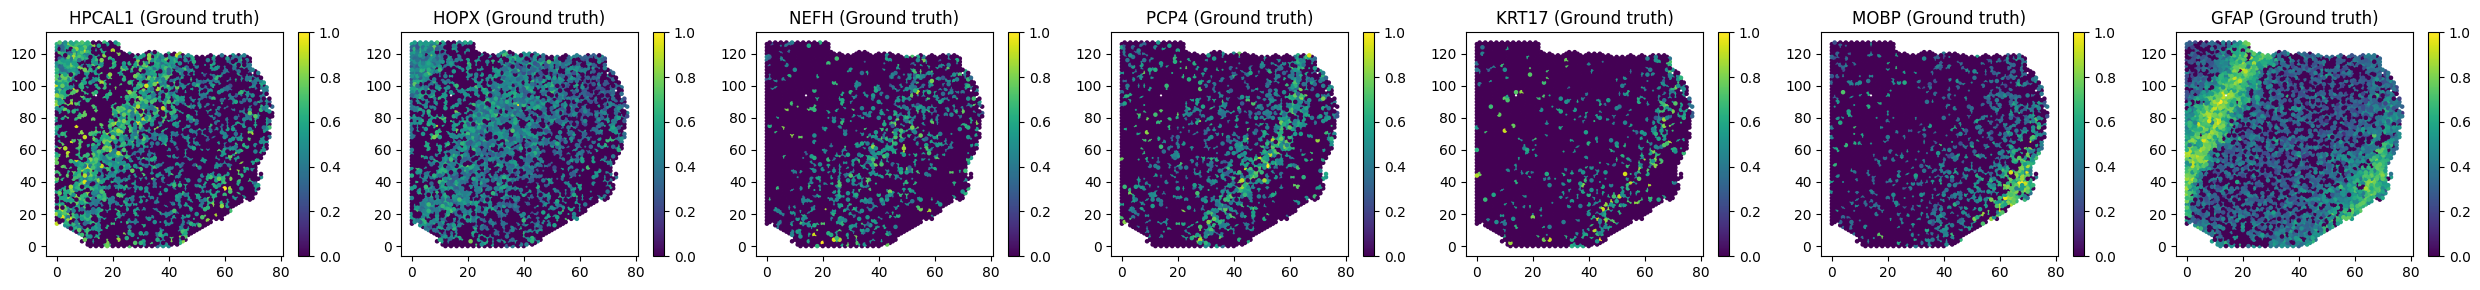

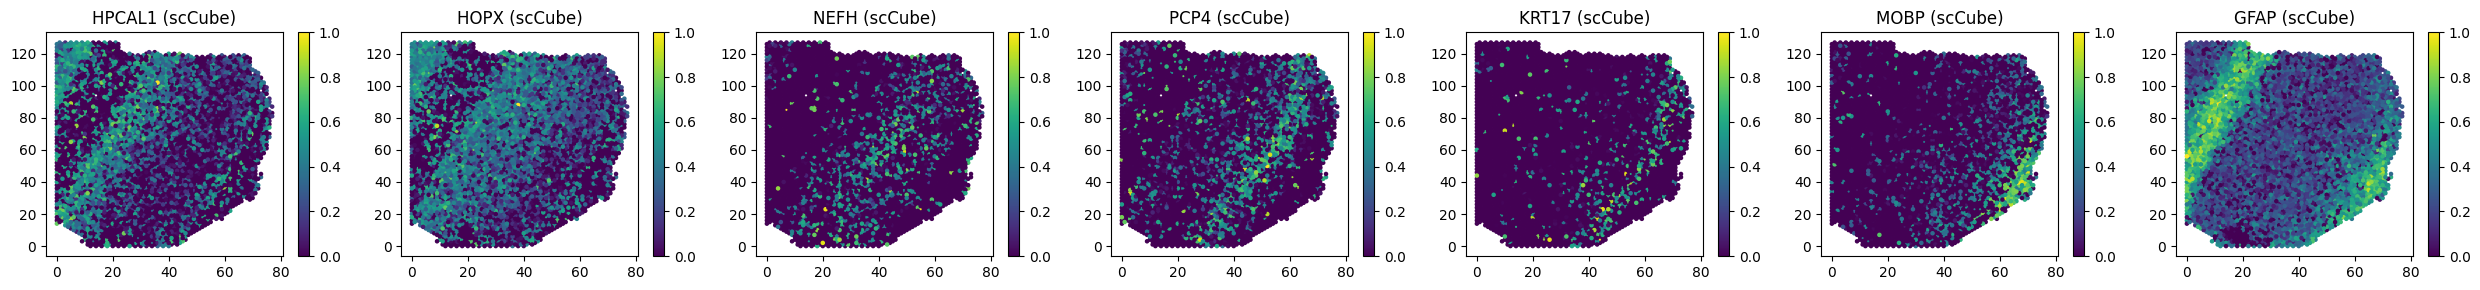

In [7]:
genes = ['HPCAL1', 'HOPX', 'NEFH', 'PCP4', 'KRT17', 'MOBP','GFAP']

# real data
obj = sc_meta
obj.index = list(obj['Cell'])
gene_exp = sc_data.T[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,7,figsize=(25, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=5, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (Ground truth)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()

# scCube
obj = generate_sc_meta
obj.index = list(obj['Cell'])
gene_exp = generate_sc_data.T[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,7, figsize=(25, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=5, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (scCube)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()
plt.show()

In [8]:
sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

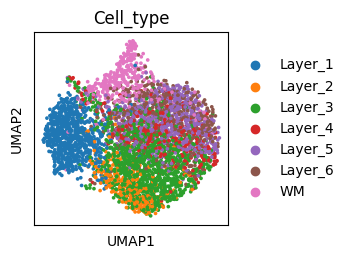

In [9]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [10]:
# avoid error in sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
generate_sc_meta_rep = generate_sc_meta.set_index(keys='Cell', drop=False)
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta_rep,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

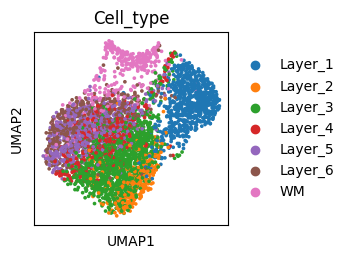

In [11]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [12]:
# Ground truth vissulization
generate_sc_meta = generate_sc_meta.rename(columns={'x': 'point_x', 'y': 'point_y'})
generate_sc_data = generate_sc_data.rename(columns={'x': 'point_x', 'y': 'point_y'})

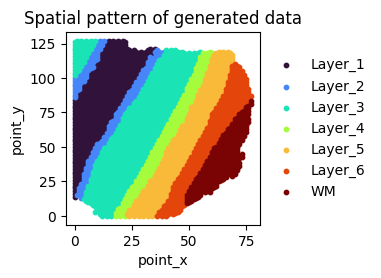

In [13]:
#reference
plot_spatial_pattern_scatter(
    obj=generate_sc_meta,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_type',
    colormap='turbo',
    size=10,
    alpha=1)
plt.show()